In [1]:
import sys
import numpy as np
import scipy
import subprocess
from natsort import natsorted
import itertools
import pandas as pd
import torch
sys.path.append("../utls")
sys.path.append("../utls")
sys.path.append("../.")
sys.path.append("../models")
from collections import Counter
import os
import gc
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle
import string
import shutil
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
import torch.nn.functional as F
from torch.autograd import Function
import torchvision
import torchvision.transforms
from sklearn.preprocessing import StandardScaler, LabelEncoder
from utls.preprocessing import cm_std, centimeter
from utls.postprocessing import get_dataset, generate_hist_df, make_model, read_trained_model, get_confution_matrix
from InterfaceDeclaration import LPBFInterface
from models.MLUtls import fade_in_out, standardize_tensor, getKFoldCrossValidationIndexes, train_log, transform_ft, dataset_by_cross_validation, labels_by_classes, get_current_fold_and_hist, LPBFDataset
from models.MLModels import SVMModel, CNN_Base_1D_Model, ResNet15_1D_Model

plt.rcParams["figure.dpi"] = 300
plt.style.use(["science", "nature"])
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['text.usetex']= True if shutil.which('latex') else False

alphabet = list(string.ascii_lowercase)

project_name = ["MuSIC", "MaPS", "MuSIC_EXP1"]
if os.name == "posix":
    data_dir = subprocess.getoutput("echo $DATADIR")
elif os.name == "nt":
    data_dir = subprocess.getoutput("echo %datadir%")
music_dir = os.path.join(data_dir, "MuSIC")
if not os.path.exists(music_dir):
    project_name[0] = "2024-MUSIC"
daq_dir = os.path.join(data_dir, *project_name, "Acoustic Monitoring")
lmq_dir = os.path.join(data_dir, *project_name, "LMQ Monitoring")
del music_dir

sampling_rate_daq: int = int(1.25 * 1e6)
sampling_rate_lmq: int = int(0.1 * 1e6)
tdms_daq_list = natsorted(
    [i for i in os.listdir(daq_dir) if i.split(".")[-1] == "tdms"]
)
bin_lmq_list = natsorted([i for i in os.listdir(lmq_dir) if i.split(".")[-1] == "bin"])
lmq_channel_name = [
    "Vector ID",
    "meltpooldiode",
    "X Coordinate",
    "Y Coordinate",
    "Laser power",
    "Spare",
    "Laser diode",
    "Varioscan(focal length)",
]
process_regime = [
    [0,    59, "Base"  ], 
    [60,  129, "KH"    ], 
    [130, 199, "Normal"], 
    [200, 269, "RLoF"  ], 
    [269, 339, "LoF"   ] 
]


with open(os.path.join("../",'outputs',"intermediate",f"sc_power.pkl"), 'rb') as handle:
    sc_power = pickle.load(handle)

with open(os.path.join("../",'outputs',"intermediate",f"le_speed.pkl"), 'rb') as handle:
    le_speed = pickle.load(handle)

with open(os.path.join("../",'outputs',"intermediate",f"le_region.pkl"), 'rb') as handle:
    le_region = pickle.load(handle)

with open(os.path.join("../",'outputs',"intermediate",f"le_direction.pkl"), 'rb') as handle:
    le_direction = pickle.load(handle)

In [2]:
dataset,sc_power,le_direction,le_speed,le_region = get_dataset()

In [3]:
max_epochs=50
his_dir = os.path.join(os.pardir,"lfs","weights/hist")
snap_dir = os.path.join(os.pardir,"lfs","weights/")
model_name= ["CNN"]
acoustic_type =['ae','mic'] 
context_type = []
# context_type = ['energy']
output_type = ['direction']
folds = 10

df = generate_hist_df(his_dir,model_name,acoustic_type,context_type,output_type,folds,max_epochs)
df['Input Type'] = df['Input type'].str.replace('+', '\n')

In [4]:
data_loader = DataLoader(dataset, batch_size=1000, shuffle=False)

In [5]:
model,snap_list = read_trained_model(snap_dir,model_name,acoustic_type,context_type,output_type,folds,max_epochs)

## Grad-CAM for a singal input

In [6]:
class GradCAM:
    def __init__(self, model, target_layer):
        """
        Initializes the GradCAM object.
        
        Args:
            model: The trained PyTorch model.
            target_layer: The layer name of the target convolutional layer.
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook the target layer
        target_layer.register_forward_hook(self._forward_hook)
        target_layer.register_backward_hook(self._backward_hook)

    def _forward_hook(self, module, input, output):
        """Hook to get the activations."""
        self.activations = output

    def _backward_hook(self, module, grad_input, grad_output):
        """Hook to get the gradients."""
        self.gradients = grad_output[0]

    def __call__(self, input_tensor, target_class=None):
        """
        Computes the Grad-CAM heatmap.
        
        Args:
            input_tensor: The input tensor (1D array reshaped as a batch).
            target_class: The target class index for which Grad-CAM is computed. If None, uses the predicted class.

        Returns:
            heatmap: The Grad-CAM heatmap.
        """
        # Forward pass
        self.model.eval()
        output = self.model(input_tensor)

        # Select target class
        if target_class is None:
            probs = torch.sigmoid(output)
            target_class = torch.argmax(probs,axis=1).clone().int().detach().cpu().item()

        # Backward pass
        self.model.zero_grad()
        one_hot_output = torch.zeros_like(output)
        one_hot_output[0, target_class] = 1
        output.backward(gradient=one_hot_output)

        # Compute weights and Grad-CAM
        weights = torch.mean(self.gradients, dim=2, keepdim=True)  # Global average pooling of gradients
        grad_cam = torch.sum(weights * self.activations, dim=1).squeeze()  # Weighted sum of activations

        # Apply ReLU to focus on positive contributions
        grad_cam = F.relu(grad_cam)

        # Normalize heatmap
        # heatmap = grad_cam
        heatmap = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())
        return heatmap.detach().cpu().numpy(),target_class


def zero_reference_shift(data, n):
    """
    Shifts the data to use the first 'n' data points as the zero reference.

    Args:
        data (numpy.ndarray): The 1D data array.
        n (int): The number of initial data points to use as the zero reference.

    Returns:
        numpy.ndarray: The shifted data.
    """
    if n <= 0 or n > len(data):
        raise ValueError("n must be between 1 and the length of the data array.")

    # Compute the reference value as the mean of the first 'n' data points
    zero_reference = np.mean(data[:n])

    # Subtract the zero reference from all data points
    shifted_data = data - zero_reference

    return shifted_data

In [7]:
_model_name= "CNN"
_inputs = "ae"
_outputs = "direction"
f_i = 0
snap_name = f"{_model_name}_classification_input_{_inputs}_output_{_outputs}_roi_time10_roi_radius3_fold{f_i}_of_folds10.pt"
snap_name = os.path.join(snap_dir,snap_name)
snapshot = torch.load(snap_name, map_location=f"cuda:0", weights_only=True)
_state_dict = snapshot["model_state_dict"]
model.load_state_dict(_state_dict)
model = model.to('cuda')

grad_cam = GradCAM(model=model,target_layer=model.conv3)

In [8]:
# _cube_position, _laser_power, _scanning_speed, _regime_info, _print_direction, _mic, _ae, _defect_labels = next(iter(data_loader))
# time_series_inputs = (transform_ft()(standardize_tensor(_ae))).double().to('cuda:0')
# logits = model(time_series_inputs)
# probs = torch.sigmoid(logits)
# pred = torch.argmax(probs,axis=1).clone().int().detach().cpu()
# pred, _ae

c:\Users\mingwucn\.conda\envs\ai\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


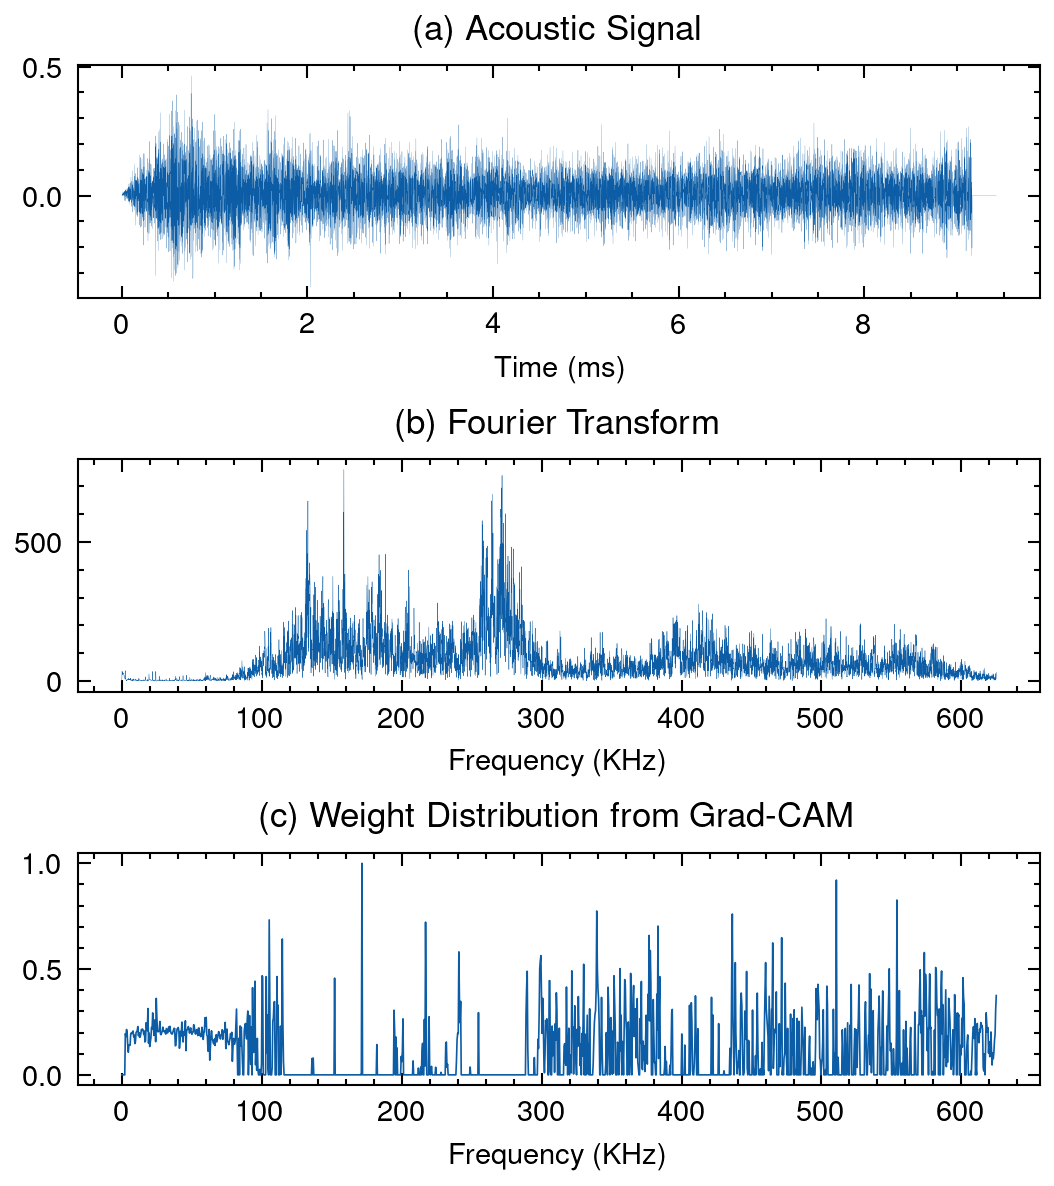

tensor(False)

In [9]:
# data_loader = DataLoader(dataset, batch_size=1, shuffle=False)
_cube_position, _laser_power, _scanning_speed, _regime_info, _print_direction, _mic, _ae, _defect_labels = next(iter(data_loader))
time_series = _ae[0]
freq = np.fft.fftfreq(5888*2, d=1/sampling_rate_daq)[:5888]/1000
time_series_ft = (transform_ft()(standardize_tensor(time_series.unsqueeze(0)))).double().to('cuda:0')
_t = np.linspace(0,len(time_series)/sampling_rate_daq*1e3,len(time_series))
heatmap,pred = grad_cam(time_series_ft)
# heatmap = np.abs(zero_reference_shift(heatmap,180))
# if pred==_print_direction[0]:
freq_h = np.linspace(0,max(freq),len(heatmap))
fig,ax = plt.subplots(nrows=3,figsize=(3.5,2.625*1.5))
ax[0].plot(_t, time_series,lw=0.05,c=cm_std[0])
ax[1].plot(freq, time_series_ft[0].cpu(),lw=0.10,c=cm_std[0])
ax[2].plot(freq_h,heatmap,lw=0.4,c=cm_std[0])
ax[0].set_title(f"(a) Acoustic Signal")
ax[1].set_title(f"(b) Fourier Transform")
ax[2].set_title(f"(c) Weight Distribution from Grad-CAM")
ax[0].set_xlabel(f"Time (ms)")
ax[1].set_xlabel(f"Frequency (KHz)")
ax[2].set_xlabel(f"Frequency (KHz)")

plt.savefig(f"../outputs/raw_gradcam_signal.png",dpi=600)
plt.show()
pred==_print_direction[0]

In [ ]:
angle_0_ae_direction = []
angle_1_ae_direction = []
angle_2_ae_direction = []
angle_3_ae_direction = []
angle_0_mic_direction = []
angle_1_mic_direction = []
angle_2_mic_direction = []
angle_3_mic_direction = []

_model_name= "CNN"
_inputs = "ae"
_outputs = "direction"
f_i = 4
snap_name = f"{_model_name}_classification_input_{_inputs}_output_{_outputs}_roi_time10_roi_radius3_fold{f_i}_of_folds10.pt"
snap_name = os.path.join(snap_dir,snap_name)
snapshot = torch.load(snap_name, map_location=f"cuda:0", weights_only=True)
_state_dict = snapshot["model_state_dict"]
model.load_state_dict(_state_dict)
model = model.to('cuda')
grad_cam = GradCAM(model=model,target_layer=model.conv3)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

for data in data_loader:
    _cube_position, _laser_power, _scanning_speed, _regime_info, _print_direction, _mic, _ae, _defect_labels = data
    if _print_direction != 2:
        time_series = _ae[0]
        freq = np.fft.fftfreq(5888*2, d=1/sampling_rate_daq)[:5888]/1000
        time_series_ft = (transform_ft()(standardize_tensor(time_series.unsqueeze(0)))).double().to('cuda:0')
        _t = np.linspace(0,len(time_series)/sampling_rate_daq*1e3,len(time_series))
        heatmap,pred = grad_cam(time_series_ft)
        if pred ==_print_direction[0]:
            match pred:
                case 0:
                    angle_0_ae_direction.append(heatmap)
                case 1:
                    angle_1_ae_direction.append(heatmap)
                case 3:
                    angle_2_ae_direction.append(heatmap)
                case 4:
                    angle_3_ae_direction.append(heatmap)
                    

_model_name= "CNN"
_inputs = "mic"
_outputs = "direction"
f_i = 0
snap_name = f"{_model_name}_classification_input_{_inputs}_output_{_outputs}_roi_time10_roi_radius3_fold{f_i}_of_folds10.pt"
snap_name = os.path.join(snap_dir,snap_name)
snapshot = torch.load(snap_name, map_location=f"cuda:0", weights_only=True)
_state_dict = snapshot["model_state_dict"]
model.load_state_dict(_state_dict)
model = model.to('cuda')
grad_cam = GradCAM(model=model,target_layer=model.conv3)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

for data in data_loader:
    _cube_position, _laser_power, _scanning_speed, _regime_info, _print_direction, _mic, _ae, _defect_labels = data
    if _print_direction != 2:
        time_series = _mic[0]
        freq = np.fft.fftfreq(5888*2, d=1/sampling_rate_daq)[:5888]/1000
        time_series_ft = (transform_ft()(standardize_tensor(time_series.unsqueeze(0)))).double().to('cuda:0')
        _t = np.linspace(0,len(time_series)/sampling_rate_daq*1e3,len(time_series))
        heatmap,pred = grad_cam(time_series_ft)
        if pred ==_print_direction[0]:
            match pred:
                case 0:
                    angle_0_mic_direction.append(heatmap)
                case 1:
                    angle_1_mic_direction.append(heatmap)
                case 3:
                    angle_2_mic_direction.append(heatmap)
                case 4:
                    angle_3_mic_direction.append(heatmap)

with open(os.path.join('../lfs',"intermediate",f"angle_0_ae_direction.pkl"), 'wb') as handle:
    pickle.dump(angle_0_ae_direction,handle)
with open(os.path.join('../lfs',"intermediate",f"angle_1_ae_direction.pkl"), 'wb') as handle:
    pickle.dump(angle_1_ae_direction,handle)
with open(os.path.join('../lfs',"intermediate",f"angle_2_ae_direction.pkl"), 'wb') as handle:
    pickle.dump(angle_2_ae_direction,handle)
with open(os.path.join('../lfs',"intermediate",f"angle_3_ae_direction.pkl"), 'wb') as handle:
    pickle.dump(angle_3_ae_direction,handle)

with open(os.path.join('../lfs',"intermediate",f"angle_0_mic_direction.pkl"), 'wb') as handle:
    pickle.dump(angle_0_mic_direction,handle)
with open(os.path.join('../lfs',"intermediate",f"angle_1_mic_direction.pkl"), 'wb') as handle:
    pickle.dump(angle_1_mic_direction,handle)
with open(os.path.join('../lfs',"intermediate",f"angle_2_mic_direction.pkl"), 'wb') as handle:
    pickle.dump(angle_2_mic_direction,handle)
with open(os.path.join('../lfs',"intermediate",f"angle_3_mic_direction.pkl"), 'wb') as handle:
    pickle.dump(angle_3_mic_direction,handle)

In [10]:
position_0_ae_position = []
position_1_ae_position = []
position_2_ae_position = []
position_3_ae_position = []
position_4_ae_position = []
position_0_mic_position = []
position_1_mic_position = []
position_2_mic_position = []
position_3_mic_position = []
position_4_mic_position = []

_model_name= "CNN"
_inputs = "ae"
_outputs = "position"
f_i = 4
snap_name = f"{_model_name}_classification_input_{_inputs}_output_{_outputs}_roi_time10_roi_radius3_fold{f_i}_of_folds10.pt"
snap_name = os.path.join(snap_dir,snap_name)
snapshot = torch.load(snap_name, map_location=f"cuda:0", weights_only=True)
_state_dict = snapshot["model_state_dict"]
model.load_state_dict(_state_dict)
model = model.to('cuda')
grad_cam = GradCAM(model=model,target_layer=model.conv3)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

for data in data_loader:
    _cube_position, _laser_power, _scanning_speed, _regime_info, _print_position, _mic, _ae, _defect_labels = data
    time_series = _ae[0]
    freq = np.fft.fftfreq(5888*2, d=1/sampling_rate_daq)[:5888]/1000
    time_series_ft = (transform_ft()(standardize_tensor(time_series.unsqueeze(0)))).double().to('cuda:0')
    _t = np.linspace(0,len(time_series)/sampling_rate_daq*1e3,len(time_series))
    heatmap,pred = grad_cam(time_series_ft)
    if pred ==_print_position[0]:
        match pred:
            case 0:
                position_0_ae_position.append(heatmap)
            case 1:
                position_1_ae_position.append(heatmap)
            case 2:
                position_2_ae_position.append(heatmap)
            case 3:
                position_3_ae_position.append(heatmap)
            case 4:
                position_4_ae_position.append(heatmap)
                    

_model_name= "CNN"
_inputs = "mic"
_outputs = "position"
f_i = 0
snap_name = f"{_model_name}_classification_input_{_inputs}_output_{_outputs}_roi_time10_roi_radius3_fold{f_i}_of_folds10.pt"
snap_name = os.path.join(snap_dir,snap_name)
snapshot = torch.load(snap_name, map_location=f"cuda:0", weights_only=True)
_state_dict = snapshot["model_state_dict"]
model.load_state_dict(_state_dict)
model = model.to('cuda')
grad_cam = GradCAM(model=model,target_layer=model.conv3)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

for data in data_loader:
    _cube_position, _laser_power, _scanning_speed, _regime_info, _print_position, _mic, _ae, _defect_labels = data
    time_series = _mic[0]
    freq = np.fft.fftfreq(5888*2, d=1/sampling_rate_daq)[:5888]/1000
    time_series_ft = (transform_ft()(standardize_tensor(time_series.unsqueeze(0)))).double().to('cuda:0')
    _t = np.linspace(0,len(time_series)/sampling_rate_daq*1e3,len(time_series))
    heatmap,pred = grad_cam(time_series_ft)
    if pred ==_print_position[0]:
        match pred:
            case 0:
                position_0_mic_position.append(heatmap)
            case 1:
                position_1_mic_position.append(heatmap)
            case 2:
                position_2_mic_position.append(heatmap)
            case 3:
                position_3_mic_position.append(heatmap)
            case 4:
                position_4_mic_position.append(heatmap)

with open(os.path.join('../lfs',"intermediate",f"position_0_ae_position.pkl"), 'wb') as handle:
    pickle.dump(position_0_ae_position,handle)
with open(os.path.join('../lfs',"intermediate",f"position_1_ae_position.pkl"), 'wb') as handle:
    pickle.dump(position_1_ae_position,handle)
with open(os.path.join('../lfs',"intermediate",f"position_2_ae_position.pkl"), 'wb') as handle:
    pickle.dump(position_2_ae_position,handle)
with open(os.path.join('../lfs',"intermediate",f"position_3_ae_position.pkl"), 'wb') as handle:
    pickle.dump(position_3_ae_position,handle)
with open(os.path.join('../lfs',"intermediate",f"position_4_ae_position.pkl"), 'wb') as handle:
    pickle.dump(position_4_ae_position,handle)

with open(os.path.join('../lfs',"intermediate",f"position_0_mic_position.pkl"), 'wb') as handle:
    pickle.dump(position_0_mic_position,handle)
with open(os.path.join('../lfs',"intermediate",f"position_1_mic_position.pkl"), 'wb') as handle:
    pickle.dump(position_1_mic_position,handle)
with open(os.path.join('../lfs',"intermediate",f"position_2_mic_position.pkl"), 'wb') as handle:
    pickle.dump(position_2_mic_position,handle)
with open(os.path.join('../lfs',"intermediate",f"position_3_mic_position.pkl"), 'wb') as handle:
    pickle.dump(position_3_mic_position,handle)
with open(os.path.join('../lfs',"intermediate",f"position_4_mic_position.pkl"), 'wb') as handle:
    pickle.dump(position_4_mic_position,handle)